# Notebook 02: Model Evaluation

In this notebook we will:

1. Load our preprocessed validation data and trained models  
2. Evaluate the baseline logistic regression and our neural network on the same hold-out set  
3. Compute and compare key metrics (Accuracy, ROC-AUC, Confusion Matrix)  
4. Plot the ROC curves for both models  

By the end, we’ll have a clear picture of whether the neural network adds meaningful gains over the linear baseline.

In [3]:
# Setting up the path
import os, sys

# Make sure Python can see the project’s root folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.model import SimpleHabitabilityNet

In [4]:
# 1) Imports and setup
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

from src.model import SimpleHabitabilityNet

# Where our artifacts live
ARTIFACT_DIR = os.path.join("..", "data", "artifacts")

# Load validation data
X_val = np.load(os.path.join(ARTIFACT_DIR, "X_val.npy"))
y_val = np.load(os.path.join(ARTIFACT_DIR, "y_val.npy"))

# Load baseline model (re-fit here for reproducibility)
clf = LogisticRegression(max_iter=1000, random_state=42)
X_train = np.load(os.path.join(ARTIFACT_DIR, "X_train.npy"))
y_train = np.load(os.path.join(ARTIFACT_DIR, "y_train.npy"))
clf.fit(X_train, y_train)  # train on full training split

# Predict with baseline
y_pred_baseline = clf.predict(X_val)
y_proba_baseline = clf.predict_proba(X_val)[:, 1]

# Metrics for baseline
acc_base = accuracy_score(y_val, y_pred_baseline)
auc_base = roc_auc_score(y_val, y_proba_baseline)
cm_base  = confusion_matrix(y_val, y_pred_baseline)

print("=== Baseline Logistic Regression ===")
print(f"Accuracy : {acc_base:.3f}")
print(f"ROC-AUC  : {auc_base:.3f}")
print("Confusion Matrix:\n", cm_base)

=== Baseline Logistic Regression ===
Accuracy : 0.975
ROC-AUC  : 0.865
Confusion Matrix:
 [[745   2]
 [ 17   0]]


## Evaluate Neural Network on Validation Set

Next, we’ll load our trained PyTorch model, compute its predictions on the same validation data, and calculate key metrics (Accuracy, ROC-AUC) plus the confusion matrix. This lets us directly compare its performance to the logistic‐regression baseline above.


In [5]:
# Load dependencies and data
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from src.model import SimpleHabitabilityNet

# Paths
ARTIFACT_DIR = os.path.join("..", "data", "artifacts")
X_val = np.load(os.path.join(ARTIFACT_DIR, "X_val.npy"))
y_val = np.load(os.path.join(ARTIFACT_DIR, "y_val.npy"))

# Load and prepare model
device = torch.device("cpu")
model = SimpleHabitabilityNet(input_dim=8).to(device)
model.load_state_dict(torch.load(os.path.join(ARTIFACT_DIR, "model.pth"), map_location=device))
model.eval()

# Get predicted probabilities and class predictions
with torch.no_grad():
    logits = model(torch.from_numpy(X_val).float())
    probs_nn = torch.sigmoid(logits).numpy()
y_pred_nn = (probs_nn >= 0.5).astype(int)

# Compute metrics
acc_nn = accuracy_score(y_val, y_pred_nn)
auc_nn = roc_auc_score(y_val, probs_nn)
cm_nn  = confusion_matrix(y_val, y_pred_nn)

print("=== Neural Network ===")
print(f"Accuracy : {acc_nn:.3f}")
print(f"ROC-AUC  : {auc_nn:.3f}")
print("Confusion Matrix:")
print(cm_nn)


=== Neural Network ===
Accuracy : 0.978
ROC-AUC  : 0.981
Confusion Matrix:
[[741   6]
 [ 11   6]]


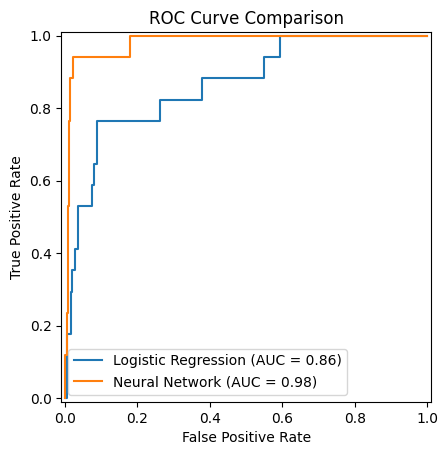

In [6]:
# Plot ROC Curves for Baseline vs. Neural Network
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay
import torch
from src.model import SimpleHabitabilityNet

ARTIFACT_DIR = os.path.join("..", "data", "artifacts")

# Load data
X_train = np.load(os.path.join(ARTIFACT_DIR, "X_train.npy"))
y_train = np.load(os.path.join(ARTIFACT_DIR, "y_train.npy"))
X_val   = np.load(os.path.join(ARTIFACT_DIR, "X_val.npy"))
y_val   = np.load(os.path.join(ARTIFACT_DIR, "y_val.npy"))

# Baseline probabilities
clf = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
base_probs = clf.predict_proba(X_val)[:, 1]

# Neural net probabilities
device = torch.device("cpu")
model = SimpleHabitabilityNet(input_dim=8).to(device)
model.load_state_dict(torch.load(os.path.join(ARTIFACT_DIR, "model.pth"), map_location=device))
model.eval()
with torch.no_grad():
    logits = model(torch.from_numpy(X_val).float())
    nn_probs = torch.sigmoid(logits).numpy()

# Plot
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_val, base_probs, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(y_val, nn_probs,   name="Neural Network",       ax=ax)
ax.set_title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


- **False Positives (FP):** increased from 2 → 6  
- **False Negatives (FN):** decreased from 17 → 11  
- **True Positives (TP):** improved from 0 → 6  
- **True Negatives (TN):** decreased from 745 → 741  

Although the neural network makes more false-positive mistakes, it catches **6 true habitable planets** that the logistic regression missed—reducing false negatives by 6. Given the high importance of identifying potentially habitable worlds (even at the cost of a few extra false alarms), this trade-off can be quite valuable.

Furthermore, the NN’s ROC-AUC jumped from **0.865 → 0.981**, demonstrating **dramatically better ranking ability** across all probability thresholds. This confirms that despite similar accuracy, the neural net’s continuous scoring yields far more discriminative power when sorting borderline cases.

---

**Conclusion:**  
- The logistic‐regression baseline is already strong (97.5% accuracy), but fails to identify any true positives.  
- The neural network offers a **modest accuracy gain (97.8%)** but, more importantly, a **substantial improvement in ROC-AUC** and ability to detect actual habitable candidates.  
- Given our project goal—to highlight potentially life-supporting exoplanets—the NN’s improved recall on the positive class and superior ranking make it the preferred model.

**Next Steps:**  
1. Explore **threshold tuning** to balance FP vs. FN for specific mission criteria.  
2. Add **feature engineering** (e.g., bulk density, stellar luminosity) to further boost performance.  
3. Integrate **SHAP** or **LIME** to interpret key drivers of habitability predictions.  
4. Optionally, deploy a **Streamlit** dashboard where users input planetary parameters and see habitability scores in real time.  